## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSBBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
526
+-------------------+-------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|            coeff_1|            coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+-------------------+-------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|-6615.4261883815225| -1465.987507716528|1026.7093734928912|   1809.6|SSSBSBBB| 39.3239|-120.2331|       SNWD|0.20641434500585848| 0.1636235425190454| 0.1445210993344531|0.6540

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00042467| 39.3239|-120.2331|   1809.6|-6615.4261883815225|
|USC00048758| 39.1678|-120.1428|   1898.9|  -7296.17630890955|
|USC00041018| 39.4539|-120.6556|   1641.3| -8170.257397429628|
|USC00049043| 39.3331| -120.173|   1774.9| -4290.462739664548|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [7]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
17,US1CAPC0001,39.3021,-120.3837,2099.2,1,-4773.255058
3,USC00040747,39.3000,-120.5167,1751.1,2,-5025.445267


In [8]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#840000'

## Map

In [9]:
min_lat,max_lat,min_long,max_long = box = (39.1181, 39.8056, -121.0500, -115.9622)


In [10]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

The Spearman Rank Correlation : -0.520244461421 
P-value = 0.00161109201586
Coefficients:[[-3.92927939]] 
Intercept : [ 4147.27469965]
Mean squared error:578 mm
R2 Statistic : 0.34


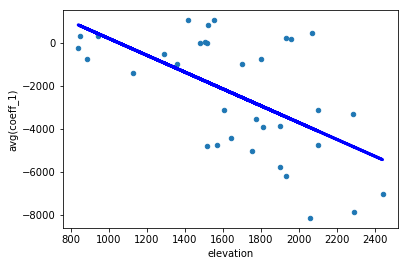

In [58]:
%matplotlib inline

import scipy.stats
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

# Compute Correlation
rho,pval = scipy.stats.spearmanr(pdf['avg(coeff_1)'],pdf['elevation']) 
#Display corr and p-value
print ('The Spearman Rank Correlation : {} \nP-value = {}'.format(rho,pval))


# Create Linear Regression Object
regr = linear_model.LinearRegression(fit_intercept = True)

y = np.transpose(np.matrix(pdf['avg(coeff_1)']))#np.array(pdf['avg(coeff_1)']).reshape(len(x),1)
x =np.transpose(np.matrix(pdf['elevation']))# pdf['elevation']

#print "len of x{} and y{}".format(x.shape,y.shape)
# Train the model
regr.fit(x,y)


# The coefficients
print('Coefficients:{} \nIntercept : {}'.format( regr.coef_,regr.intercept_))

# The mean squared error
rr = np.transpose(regr.predict(x)- y).shape
lrr = len(rr)
mse = np.dot(rr,rr)/lrr
print("Mean squared error:{} mm").format(mse)

# Explained variance score: 1 is perfect prediction
print('R2 Statistic : %.2f' % regr.score(x,y))

# Plot Line
plt.plot(x, regr.predict(x), color='blue',
         linewidth=3)


In [21]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']